### Non-Local Means Comparison

The purpose of this notebook is to create a baseline similarity comparison between the low-level intensity images using non-local means image processing algorithm with the high intensity cell images.

In [1]:
import numpy as np
import skimage 
import matplotlib.pyplot as plt

from cellvision_lib import train_test_val
from scipy.stats import entropy
from skimage import data, img_as_float, img_as_ubyte, io
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.morphology import disk
from skimage.restoration import denoise_nl_means, estimate_sigma
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/gpfs/share/skynet/apps/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
import glob
import os

MAX_DEPTH = 100
NUM_SAMPLES = 109

folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'

# train, test, val = train_test_val(folder_path, channels = 1, train_pp = .67, test_pp = .165, val_pp = .165, set_seed = 1)

def get_comp_path_tuples(data_dir, comp_channel, reference_channel=6):
    comps = []
    for i in range(1, NUM_SAMPLES):
        for z in range(1, MAX_DEPTH):
            ref_path = data_dir + '/sample{}_channel{}_z{}.tif'.format(i, reference_channel, z)
            comp_path = data_dir + '/sample{}_channel{}_z{}.tif'.format(i, comp_channel, z)
            if not os.path.isfile(ref_path) or not os.path.isfile(comp_path):
                continue
            comps.append( (comp_path, ref_path) )
    return comps

channel1_comps = get_comp_path_tuples(folder_path, 1)
channel2_comps = get_comp_path_tuples(folder_path, 2)
channel3_comps = get_comp_path_tuples(folder_path, 3)
channel4_comps = get_comp_path_tuples(folder_path, 4)
channel5_comps = get_comp_path_tuples(folder_path, 5)

print(len(channel1_comps))

10488
[('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel1_z1.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel6_z1.tif'), ('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel1_z2.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel6_z2.tif'), ('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel1_z3.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel6_z3.tif'), ('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel1_z4.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel6_z4.tif'), ('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel1_z5.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel6_z5.tif'), ('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample1_channel1_z

In [4]:
# Channel 1 comps
import pickle as pkl
from time import time

def process_channel_comps(image_paths, channel):
    comps = []
    for comp_path, ref_path in image_paths:
        comp = img_as_float(io.imread(comp_path).astype(np.uint))
        ref = img_as_float(io.imread(ref_path).astype(np.uint))
        _min = ref.min()
        _max = ref.max()
        channel_mse = mse(comp, ref)
        channel_ssim = ssim(comp, ref, data_range=_max-_min)
        denoised_comp = denoise_nl_means(comp)
        channel_dn_mse = mse(denoised_comp, ref)
        channel_dn_ssim = ssim(denoised_comp, ref, data_range=_max-_min)
        comps.append( (comp_path, ref_path, channel_mse, channel_ssim, channel_dn_mse, channel_dn_ssim) )
    pkl.dump(comps, open("baseline_channel{}".format(channel), "wb"))

start = time()
# process_channel_comps(channel1_comps[0:200], 1)
# process_channel_comps(channel2_comps[0:200], 2)
# process_channel_comps(channel3_comps[0:200], 3)
# process_channel_comps(channel4_comps[0:200], 4)
# process_channel_comps(channel5_comps[0:200], 5)
end = time()
print("Elapsed time: {} seconds".format(round(end - start, 2)))

Elapsed time: 0.0 seconds


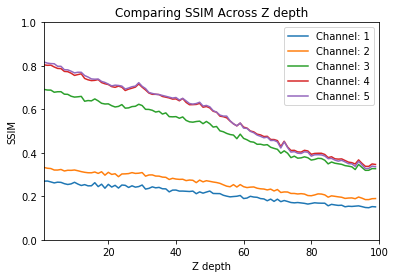

0.7059802507528532


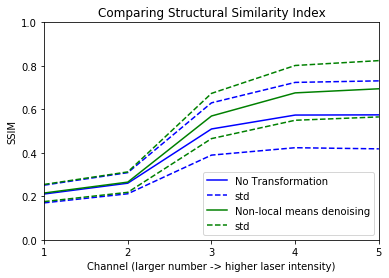

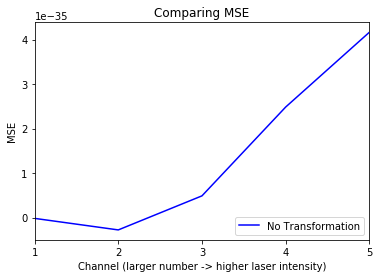

In [50]:
import statistics

channel_comps = []
for i in range(1,6):  
    with open('outputs/baseline_channel{}'.format(i), 'rb') as pickle_file:
        channel_scores = pkl.load(pickle_file)
        channel_comps.append(channel_scores)

z_means_idx = {}

mse_means = []
mse_stds = []
ssim_means = []
ssim_stds = []
mse_means_dn = []
mse_stds_dn = []
ssim_means_dn = []
ssim_stds_dn = []
for i, channel in enumerate(channel_comps):
    mse = [metric[2] for metric in channel]
    mse_std = statistics.stdev(mse)
    mse_mean = statistics.mean(mse)
    mse_means.append(mse_mean)
    mse_stds.append(mse_std)
    
    ssim = [metric[3] for metric in channel]
    ssim_std = statistics.stdev(ssim)
    ssim_mean = statistics.mean(ssim)
    ssim_means.append(ssim_mean)
    ssim_stds.append(ssim_std)
    
    mse_dn = [metric[4] for metric in channel]
    mse_dn_std = statistics.stdev(mse_dn)
    mse_dn_mean = statistics.mean(mse_dn)
    mse_means_dn.append(mse_dn_mean)
    mse_stds_dn.append(mse_dn_std)
    
    ssim_dn = [metric[5] for metric in channel]
    ssim_dn_std = statistics.stdev(ssim_dn)
    ssim_dn_mean = statistics.mean(ssim_dn)
    ssim_means_dn.append(ssim_dn_mean)
    ssim_stds_dn.append(ssim_dn_std)
    
    for metric in channel:
        z_idx = metric[0].find('_z')
        z_val = metric[0][z_idx + 2:-4]
        key = str(i + 1) + '_' + str(z_val)
        if key not in z_means_idx:
            z_means_idx[key] = [metric[3]]
        else:
            z_means_idx[key] = z_means_idx[key] + [metric[3]]
            
for key, val in z_means_idx.items():
    z_means_idx[key] = statistics.mean(val)
    

# Comparing Structural Similarity Index for denoising
MAX_DEPTH = 100
for i in range(1,6):
    channel_z_means = []
    for y in range(1,MAX_DEPTH):
        key = str(i) + '_' + str(y)
        channel_z_means.append(z_means_idx[key])
    plt.plot(list(range(1, MAX_DEPTH)), channel_z_means, label="Channel: {}".format(i)) 

plt.title('Comparing SSIM Across Z depth')
plt.legend(loc = 'upper right')
plt.ylim([0, 1])
plt.xlim([1, 100])
# plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Z depth')
plt.show()
# print(z_means_idx.keys())
print(z_means_idx['5_30'])   


# Comparing Structural Similarity Index for denoising
plt.plot(list(range(1, 6)), ssim_means, label="No Transformation", color='blue') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(ssim_means, ssim_stds)], 
         label="std",
         linestyle='--',
         color='blue') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(ssim_means, ssim_stds)], 
         linestyle='--',
         color='blue') 

plt.plot(list(range(1, 6)), ssim_means_dn, label="Non-local means denoising", color='green') 
plt.plot(list(range(1, 6)), 
         [sum(x) for x in zip(ssim_means_dn, ssim_stds_dn)], 
         label="std",
         linestyle='--',
         color='green') 
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(ssim_means_dn, ssim_stds_dn)], 
         linestyle='--',
         color='green') 

plt.title('Comparing Structural Similarity Index')
plt.legend(loc = 'lower right')
plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

# Comparing MSE for denoising
plt.plot(list(range(1, 6)), 
         [x[0] - x[1] for x in zip(mse_means, mse_means_dn)], 
         label="No Transformation", 
         color='blue') 
# plt.plot(list(range(1, 6)), 
#          [sum(x) for x in zip(mse_means, mse_stds)], 
#          label="std",
#          linestyle='--',
#          color='blue') 
# plt.plot(list(range(1, 6)), 
#          [x[0] - x[1] for x in zip(mse_means, mse_stds)], 
#          linestyle='--',
#          color='blue') 

# plt.plot(list(range(1, 6)), 
#          [x[0] - x[1] for x in zip(mse_means, mse_stds)], 
#          label="Non-local means denoising", color='green') 
# plt.plot(list(range(1, 6)), 
#          [sum(x) for x in zip(mse_means_dn, mse_stds_dn)], 
#          label="std",
#          linestyle='--',
#          color='green') 
# plt.plot(list(range(1, 6)), 
#          [x[0] - x[1] for x in zip(mse_means_dn, mse_stds_dn)], 
#          linestyle='--',
#          color='green') 

plt.title('Comparing MSE')
plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('MSE')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()
    


In [14]:
# path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009/test data_1_MMStack_Undefined1.ome.tif'
path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample28_channel1_z12.tif'
imsk = io.imread(path_to_data)
imsk.shape

PermissionError: [Errno 13] Permission denied: '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized/sample28_channel1_z12.tif'

In [11]:
# Convert everything to scaled floating values
scaled_imgs_1 = []
scaled_imgs_2 = []
scaled_imgs_3 = []
scaled_imgs_4 = []
scaled_imgs_5 = []
scaled_imgs_6 = []
for i in range(0,imsk.shape[0], 7):
    scaled_imgs_1.append(img_as_float(imsk[i,:,:].astype(np.uint)))
    scaled_imgs_2.append(img_as_float(imsk[i+1,:,:].astype(np.uint)))
    scaled_imgs_3.append(img_as_float(imsk[i+2,:,:].astype(np.uint)))
    scaled_imgs_4.append(img_as_float(imsk[i+3,:,:].astype(np.uint)))
    scaled_imgs_5.append(img_as_float(imsk[i+4,:,:].astype(np.uint)))
    scaled_imgs_6.append(img_as_float(imsk[i+5,:,:].astype(np.uint)))
print(scaled_imgs_1[0])
# print(scaled_imgs_2[0])

[[1.08962318e-17 8.07730619e-18 1.11130723e-17 ... 1.17635936e-17
  9.64939934e-18 8.07730619e-18]
 [1.03541307e-17 1.05709712e-17 1.20346441e-17 ... 8.29414662e-18
  1.01372903e-17 1.04083409e-17]
 [8.72782749e-18 8.99887803e-18 1.39862080e-17 ... 9.86623977e-18
  1.14383329e-17 1.01915004e-17]
 ...
 [3.53449908e-17 3.13876529e-17 2.81892565e-17 ... 1.37693676e-17
  1.52330405e-17 1.20888542e-17]
 [2.97613496e-17 3.11708125e-17 2.82976767e-17 ... 1.26309553e-17
  1.37693676e-17 1.33356867e-17]
 [2.74845251e-17 2.54245409e-17 2.67797937e-17 ... 1.25767452e-17
  1.51788304e-17 1.50704102e-17]]


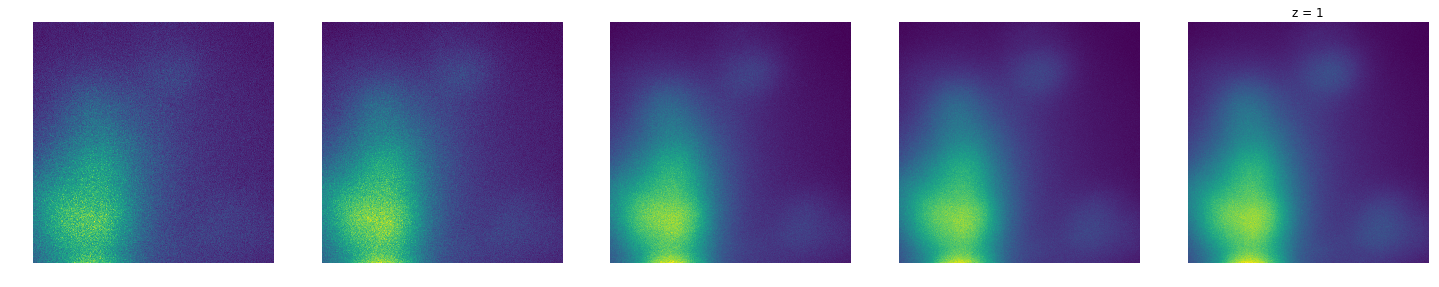

In [12]:
# for i in range(0,20,10):
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
ax[0].imshow(scaled_imgs_1[0]);
ax[0].axis('off')
ax[1].imshow(scaled_imgs_2[0]);
ax[1].axis('off')
ax[2].imshow(scaled_imgs_3[0]);
ax[2].axis('off')
ax[3].imshow(scaled_imgs_4[0]);
ax[3].axis('off')
ax[4].imshow(scaled_imgs_6[0]);
ax[4].axis('off')
plt.title('z = '+str(1))
plt.show()

In [6]:
_min = scaled_imgs[5].min()
_max = scaled_imgs[5].max()
print(ssim(scaled_imgs[0],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[1],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[2],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[3],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[4],scaled_imgs[5],data_range=_max-_min))
print(ssim(scaled_imgs[5],scaled_imgs[5],data_range=_max-_min))
print(len(scaled_imgs))

0.2351745815481035
0.2965951636780404
0.6688529668488682
0.791309008088592
0.8066083320665349
1.0
700


In [13]:
print(len(scaled_imgs_4))

100


In [28]:
denoised_imgs_1 = []
denoised_imgs_2 = []
denoised_imgs_3 = []
denoised_imgs_4 = []
denoised_imgs_5 = []
denoised_imgs_6 = []
for i in range(0,5):
    denoised_imgs_1.append(denoise_nl_means(scaled_imgs_1[i]))
    denoised_imgs_2.append(denoise_nl_means(scaled_imgs_2[i]))
    denoised_imgs_3.append(denoise_nl_means(scaled_imgs_3[i]))
    denoised_imgs_4.append(denoise_nl_means(scaled_imgs_4[i]))
    denoised_imgs_5.append(denoise_nl_means(scaled_imgs_5[i]))
    denoised_imgs_6.append(denoise_nl_means(scaled_imgs_6[i]))
    print(i)
print(denoised_imgs_1[0])

0
1
2
3
4
[[1.03400157e-17 1.03396065e-17 1.03707006e-17 ... 1.00920811e-17
  1.01051734e-17 1.01160154e-17]
 [1.03664047e-17 1.03737691e-17 1.03990331e-17 ... 1.01036391e-17
  1.01351424e-17 1.01541670e-17]
 [1.03542330e-17 1.03654842e-17 1.03915664e-17 ... 1.00846145e-17
  1.01188793e-17 1.01371880e-17]
 ...
 [3.17843072e-17 3.17763291e-17 3.19013192e-17 ... 1.34090238e-17
  1.34223206e-17 1.34264119e-17]
 [3.17674305e-17 3.17715218e-17 3.18881247e-17 ... 1.33801799e-17
  1.33850895e-17 1.33893854e-17]
 [3.16738414e-17 3.16804898e-17 3.18008771e-17 ... 1.33587004e-17
  1.33762932e-17 1.33823279e-17]]


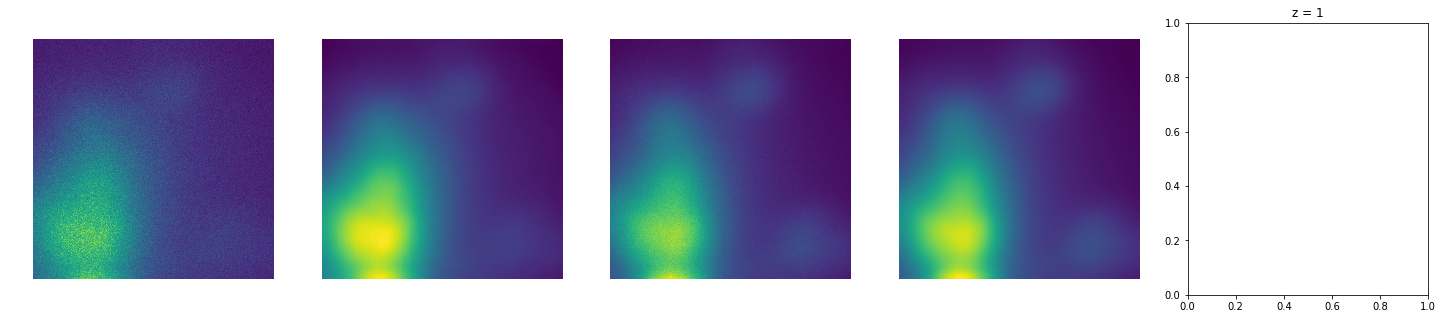

0.8745049726358385


In [29]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(scaled_imgs_1[0]);
ax[0].axis('off')
ax[1].imshow(denoised_imgs_1[0]);
ax[1].axis('off')
ax[2].imshow(scaled_imgs_5[0]);
ax[2].axis('off')
ax[3].imshow(denoised_imgs_5[0]);
ax[3].axis('off')
plt.title('z = '+str(1))
plt.show()

print(ssim(denoised_imgs_4[0],scaled_imgs_5[0],data_range=_max-_min))

In [34]:
original_ssim_1 = []
nl_ssim_1 = []
for i in range(0,5):
    _min = scaled_imgs_6[i].min()
    _max = scaled_imgs_6[i].max()
    original_ssim_1.append(ssim(scaled_imgs_1[i],scaled_imgs_6[i],data_range=_max-_min))
    nl_ssim_1.append(ssim(denoised_imgs_1[i],scaled_imgs_6[i],data_range=_max-_min))
    
print(sum(original_ssim_1)/len(original_ssim_1))
print(sum(nl_ssim_1)/len(nl_ssim_1))

original_ssim_4 = []
nl_ssim_4 = []
for i in range(0,5):
    _min = scaled_imgs_6[i].min()
    _max = scaled_imgs_6[i].max()
    original_ssim_4.append(ssim(scaled_imgs_4[i],scaled_imgs_6[i],data_range=_max-_min))
    nl_ssim_4.append(ssim(denoised_imgs_4[i],scaled_imgs_6[i],data_range=_max-_min))
    
print(sum(original_ssim_4)/len(original_ssim_4))
print(sum(nl_ssim_4)/len(nl_ssim_4))

# plt.plot(list(range(0, 5)), original_ssim, label="No change") 
# plt.plot(list(range(0, 5)), nl_ssim, label="Non-local means denoising") 

# plt.title('Comparing Structural Similarity Index')
# plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
# plt.xlim([0, 4])
# plt.axes().set_xticks(list(range(0, 5)), minor=False)

# plt.ylabel('SSIM')
# plt.xlabel('Laser Intensity')
# plt.show()

    
    

0.24163101630800116
0.2435718576965907
0.7833657684941391
0.8495119218205712


In [19]:
print(sum(original_ssim_1)/len(original_ssim_1))
print(sum(nl_ssim_1)/len(nl_ssim_1))

0.2079093430928186
0.2079093430928186
